In [134]:
# Common imports
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
from numpy.random import seed

In [135]:
#energy = pd.read_csv('Energy.csv', sep=',', names=['time', 'J'])
#power = pd.read_csv('Power.csv', sep=',', names=['time','P'])
#current = pd.read_csv('Current.csv', sep=',',names=['time', 'A'])

In [136]:
energy = np.loadtxt(open('Energy.csv',"rb"), delimiter=',')
power= np.loadtxt(open('Power.csv',"rb"), delimiter=',')
current = np.loadtxt(open('Current.csv',"rb"), delimiter=',')

In [137]:
#Array manipulation and formatting. Dropping Unix time from power and current as they're redundant, and concatenating onto energy
power = power[:,1]
power = power[:,None]
current = current[:,1]
current = current[:,None]
energy = np.append(energy,power,axis=1)
energy = np.append(energy,current,axis=1)

In [138]:
#Creating column name array for pandas, unix time format is irregular, dividing by 1000 to allow for conversion
names = ['time', 'energy', 'power','current']
data = pd.DataFrame(data=energy, columns=names)
data['time'] = data['time'].floordiv(1000)

In [139]:
#Deep copying the time column to cyclic encode intervals of time. Deep copying ensures that the original column is not affected
timeData = data['time'].copy(deep=True)
timeData[1]

1401695813.0

In [140]:
#Cyclic encoding of different intervals of time
#timeData column is first converted from Unix time to datetime format
#Dates and exact times are extracted separately into two different lists
#Days and months are extracted separately into two different lists
#Hour and minute are extracted from time into two different lists
timeData[0:] = pd.to_datetime(timeData[0:], unit='s')
new_dates, new_times = zip(*[(d.date(), d.time()) for d in timeData[0:]])
new_day, new_month = zip(*[(d.day, d.month)  for d in new_dates])
hour, minute = zip(*[(d.hour, d.minute)  for d in new_times])
minutes = [format(minute[d], '02d') for d in minute]


#Times are converted in terms of sine and cosine. Multiplying by pi and dividing by the number of segments in time timeframe
#ie hours in a day is divided into 24 segments, days of week is divided into 7, months in year is divided into 12, etc.
#This ensures that the cyclic nature of time is captured and reflected within the model. In doing this, December is the same 
# distance from January as Februrary, and 11:59 PM is as close to midnight as 12:01 AM, rather than being at opposite ends.
#For the combed dataset, hour of day, day of month, and day of week are cyclically encoded to determine patterns over the course
#of a day, week, and month. 
df = pd.DataFrame(list(zip(hour, minutes,new_day,new_month)), 
               columns =['hours', 'minutes','day','month']) 
df['hourfloat']= df.hours.astype(float) + (df.minutes.astype(float))/60.0
df['hour_sin']=np.sin(2.*np.pi*df.hourfloat/24.)
df['hour_cos']=np.cos(2.*np.pi*df.hourfloat/24.)
df['day_sin'] = np.sin((df.day-1)*(2.*np.pi/30))
df['day_cos'] = np.cos((df.day-1)*(2.*np.pi/30))
df['week_sin']=np.sin(2.*np.pi*df.day/7.)
df['week_cos']=np.cos(2.*np.pi*df.day/7.)


In [141]:
df.head(10)

,hours,minutes,day,month,hourfloat,hour_sin,hour_cos,day_sin,day_cos,week_sin,week_cos
0,7,24,2,6,7.400000,0.933580,-0.358368,0.207912,0.978148,0.974928,-0.222521
1,7,24,2,6,7.400000,0.933580,-0.358368,0.207912,0.978148,0.974928,-0.222521
2,7,24,2,6,7.400000,0.933580,-0.358368,0.207912,0.978148,0.974928,-0.222521
3,7,24,2,6,7.400000,0.933580,-0.358368,0.207912,0.978148,0.974928,-0.222521
4,7,25,2,6,7.416667,0.932008,-0.362438,0.207912,0.978148,0.974928,-0.222521
5,7,25,2,6,7.416667,0.932008,-0.362438,0.207912,0.978148,0.974928,-0.222521
6,7,25,2,6,7.416667,0.932008,-0.362438,0.207912,0.978148,0.974928,-0.222521
7,7,25,2,6,7.416667,0.932008,-0.362438,0.207912,0.978148,0.974928,-0.222521
8,8,56,2,6,8.933333,0.719340,-0.694658,0.207912,0.978148,0.974928,-0.222521
9,8,56,2,6,8.933333,0.719340,-0.694658,0.207912,0.978148,0.974928,-0.222521


In [142]:
#Converts the time column to datetime, uses it as index
data['time'] = pd.to_datetime(data['time'], unit='s')
data = data.sort_index()
data.set_index('time', inplace=True)
data.head()


,energy,power,current
time,,,
2014-06-02 07:56:23,160467968.0,40767.359375,62.008255
2014-06-02 07:56:53,160468320.0,41936.476562,63.630100
2014-06-02 07:57:23,160468656.0,40863.601562,62.187214
2014-06-02 07:57:53,160469024.0,40860.156250,62.257900
2014-06-02 07:58:23,160469376.0,44302.625000,66.598312


In [143]:
#Creating a data frame to hold the encoded times 
dfEncoded = pd.DataFrame(list(zip(df.hour_sin, df.hour_cos, df.day_sin, df.day_cos, df.week_sin, df.week_cos)), 
               columns =['hour_sin', 'hour_cos', 'day_sin','day_cos','week_sin','week_cos'], index=data.index)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


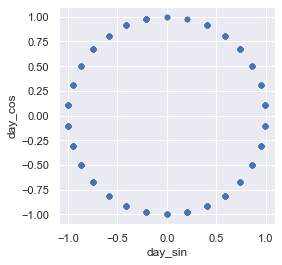

In [144]:
#Visualization of the sine cosine values for day of month, divided into 30 segments
df.sample(500).plot.scatter('day_sin','day_cos').set_aspect('equal');

In [145]:
#Preparing the current, energy, and power for normalization. Data is normalized between [0,1]

scaler = preprocessing.MinMaxScaler()
#normalized_df=(merged_data-merged_data.min())/(merged_dat-a.max()-merged_data.min())
#normalized_df=(data-data.mean())/data.std()





normalized =  pd.DataFrame(scaler.fit_transform(data),
                              columns=data.columns, 
                              index=data.index)
normalized.sample(frac=1)



#Concatenating the normalized data with the encoded temporal data
dfCombined = pd.concat([normalized, dfEncoded], axis=1)
dfCombined




,energy,power,current,hour_sin,hour_cos,day_sin,day_cos,week_sin,week_cos
time,,,,,,,,,
2014-06-02 07:56:23,0.000000,0.694100,0.688114,0.933580,-0.358368,0.207912,0.978148,0.974928,-0.222521
2014-06-02 07:56:53,0.000019,0.714005,0.706112,0.933580,-0.358368,0.207912,0.978148,0.974928,-0.222521
2014-06-02 07:57:23,0.000037,0.695739,0.690100,0.933580,-0.358368,0.207912,0.978148,0.974928,-0.222521
2014-06-02 07:57:53,0.000057,0.695680,0.690884,0.933580,-0.358368,0.207912,0.978148,0.974928,-0.222521
2014-06-02 07:58:23,0.000075,0.754291,0.739050,0.932008,-0.362438,0.207912,0.978148,0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...
2014-07-01 03:57:53,0.999943,0.531026,0.572269,0.777146,0.629320,0.000000,1.000000,0.781831,0.623490
2014-07-01 03:58:23,0.999956,0.532212,0.573410,0.779884,0.625923,0.000000,1.000000,0.781831,0.623490
2014-07-01 03:58:53,0.999971,0.583963,0.637704,0.779884,0.625923,0.000000,1.000000,0.781831,0.623490


In [52]:
df3.to_csv('combed.csv')